### Visualization
We will visualize the results after training in this notebook. 
- Plain sampling oversamples empty spaces in the western united states, so we cherrypick some good samples
- The results are very finicky if we pick any sample and try embedding manipulations; So, we try to cherry pick some good examples.
- This need should go away once we have a decent trainned example
- all these indices are for level14 zoom and tiles generated using url generator. If that file changes, all these will become garbage.

### Common Setup

In [62]:
%load_ext autoreload
%autoreload 2

In [63]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style("darkgrid")
from PIL import Image
from torchvision import transforms
import torch

import torchvision
from torch.utils.data.sampler import WeightedRandomSampler
from tensorboardX import SummaryWriter
import seaborn as sns
sns.set_style("darkgrid")

In [64]:
from networks import Loc2Vec
from datasets import GeoTileInferDataset, get_files_from_path, cleanse_files
from config import IMG_SIZE
# from map_network import Geo2Vec
# from map_datasets import GeoTileInferDataset, IMG_SIZE, get_files_from_path, cleanse_files

In [65]:
cuda = torch.cuda.is_available()

In [66]:
checkpoint_file = './checkpoint_1.pth'

In [67]:
model = Loc2Vec()
model = torch.load(checkpoint_file)
model.eval()
if cuda:
    model.cuda()

In [68]:
infer_transforms = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
bs = 56
dset_eval = GeoTileInferDataset("/files/datasets/lacmus-ds/ladd_crop/base",
                                center_transform=infer_transforms)
pd_files = dset_eval.get_file_df()
weights = pd_files.frequency
infer_sampler = WeightedRandomSampler(weights, len(dset_eval))
# Should numworkers be 1?
kwargs = {'num_workers': 8, 'pin_memory': True} if cuda else {}
online_eval_loader = torch.utils.data.DataLoader(dset_eval, batch_size=bs,
                                                 sampler=infer_sampler, **kwargs)

304544


### Get all embedding and store
we shall use the annoy library store all the vectors and built a tree based on the euclidean distance for fast retrival

In [69]:
from annoy import AnnoyIndex
t = AnnoyIndex(16, metric='euclidean')  # Length of item vector that will be indexed

In [70]:
with torch.no_grad():
    model.eval()
    val_loss = 0
    for batch_idx, (data, target) in enumerate(online_eval_loader):
        if cuda:
            data = data.cuda()
        outputs = model(data)
        for i in range(0, len(target)):
            t.add_item(target[i], outputs[i])
        if batch_idx % 1000 == 0:
            print("Processed :", batch_idx, " items")

Processed : 0  items
Processed : 1000  items
Processed : 2000  items
Processed : 3000  items
Processed : 4000  items
Processed : 5000  items


In [80]:
t.build(25)
t.save('embeddings.ann')

Exception: You can't build a loaded index

In [72]:
t.load('embeddings.ann')

True

In [73]:
pd_files =  dset_eval.get_file_df()

In [104]:
#display(pd_files)
for index in range(0,304544):
    if '/files/datasets/lacmus-ds/ladd_crop/base/Pedestrian' in str(pd_files.path[index]):
        print(index)

5339
5797
6682
7868
9504
11802
11905
13008
13998
15409
17670
21596
28272
37445
42432
45542
46221
51419
55051
55165
56155
60761
65826
66906
68029
69060
71540
72148
72582
72622
74466
75003
75064
75357
77109
77657
77811
78151
78832
79155
79199
80101
80532
81013
81659
81691
82616
82711
82990
83187
83935
85825
86753
87330
87623
87852
88179
88457
88495
88827
89034
89308
89313
89774
90456
90473
90643
91140
92455
92589
92673
92759
93193
93436
93860
93871
94133
94967
95382
95488
96346
96491
96875
97050
97158
97188
97801
98237
98407
98541
98628
98682
98754
98807
98851
99204
99358
100123
100268
100542
100546
101416
101616
101733
101787
101908
102400
102930
103149
103150
103951
103973
104120
104134
104171
104215
104391
105000
105710
105889
105925
106034
106084
106173
106249
106501
106526
106858
107032
107068
107465
107491
107712
108152
108241
108410
108418
108590
108741
108800
108873
109067
109124
110012
110013
110032
110236
110489
110615
110690
110726
110737
110854
111070
111098
111167
111293
111

183366
183372
183386
183390
183396
183399
183400
183413
183422
183431
183432
183442
183451
183454
183464
183472
183476
183495
183499
183504
183512
183513
183519
183520
183530
183542
183546
183552
183567
183570
183582
183584
183589
183590
183631
183641
183647
183649
183655
183662
183668
183686
183690
183704
183719
183727
183732
183752
183774
183788
183791
183801
183802
183804
183807
183840
183842
183857
183867
183881
183892
183894
183908
183918
183931
183937
183958
183967
183973
183980
183985
183988
183991
183995
183999
184010
184017
184030
184036
184066
184079
184095
184108
184115
184123
184126
184127
184130
184164
184172
184173
184179
184180
184200
184219
184240
184243
184244
184249
184267
184272
184281
184313
184317
184341
184352
184353
184358
184366
184374
184382
184389
184397
184398
184403
184404
184425
184426
184427
184432
184437
184448
184472
184486
184509
184519
184521
184525
184534
184540
184548
184549
184561
184562
184568
184578
184580
184590
184591
184592
184630
184631
184649

258227
258235
258291
258504
258672
258692
258778
258819
259031
259116
259281
259358
259365
259382
259448
259535
259539
259570
259621
259703
259751
259871
260234
260677
260943
261047
261124
261187
261358
261366
261433
261437
261448
261485
261529
261538
261546
261553
261589
261603
261754
261767
261776
261813
262168
262205
262333
262424
262430
262653
262716
262797
262916
263035
263063
263099
263233
263303
263321
263436
263523
263594
263601
263607
263629
263694
263705
263975
264104
264110
264272
264357
264431
264532
264539
264850
264933
264960
265287
265388
265836
266050
266076
266138
266158
266306
266360
266481
266492
266604
266631
266633
266845
266869
266882
266954
266995
267153
267189
267383
267447
267582
267649
267719
267760
267845
267906
268209
268333
268404
268718
268911
269155
269250
269367
269427
269432
269483
269546
269630
269674
269840
269981
270115
270198
270214
270362
270519
270633
270991
271027
271037
271080
271085
271185
271186
271406
271437
271555
271593
271767
271840
271926

/files/datasets/lacmus-ds/ladd_crop/base/Pedestrian/320.png


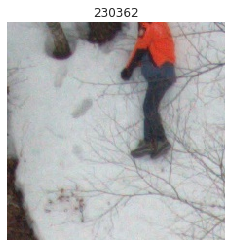

In [124]:
print(pd_files.path[219586])
img = Image.open('/files/datasets/lacmus-ds/ladd_crop/base/Background/216798.png', 'r')
img = Image.open(pd_files.path[222779], 'r')
data = img.convert('RGB')
t_img = torch.from_numpy(np.asarray(data))
t_img_np = t_img.numpy()
plt.axis('off')
plt.title(index)
plt.imshow(t_img_np)

### Sample of tiles

Cherry picked indices are used in the indices and plotted. We will cross reference this when trying to see other results like interpolation and nearest neighbors.

If we don't do this, the sampling would largely sample uninteresting areas!

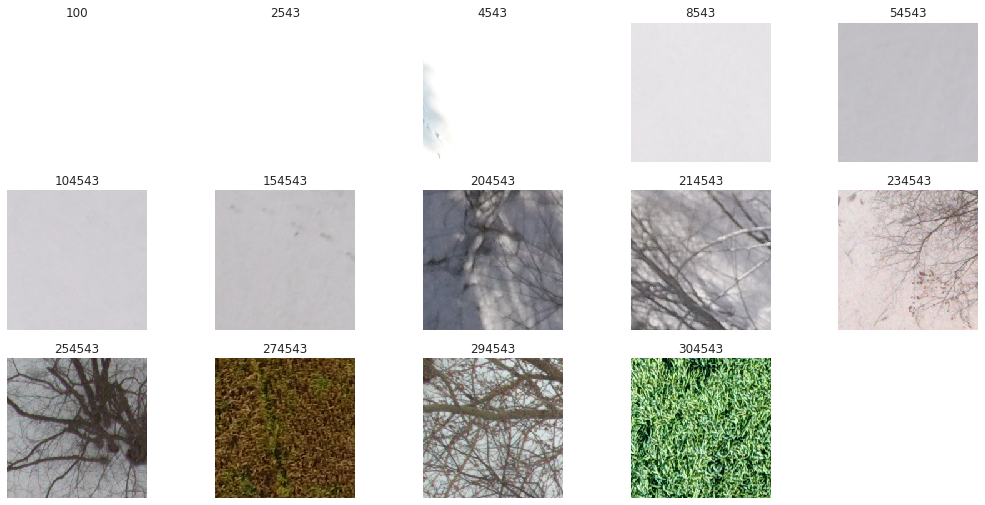

In [76]:
indices = [100, 2543, 5339, 8543, 54543,
           104543, 154543, 204543, 214543, 234543, 254543, 274543, 294543, 304543]
columns = 5
rows = 6

w = 15
h = 15
fig = plt.figure(figsize=(18, 18))

for i, index in enumerate(indices):
    img = np.random.randint(10, size=(h, w))
    fig.add_subplot(rows, columns, i+1)
    img = Image.open(pd_files.path[index], 'r')
    data = img.convert('RGB')
    t_img = torch.from_numpy(np.asarray(data))
    t_img_np = t_img.numpy()
    plt.axis('off')
    plt.title(index)
    plt.imshow(t_img_np)

plt.show()

### Find nearest neighbors

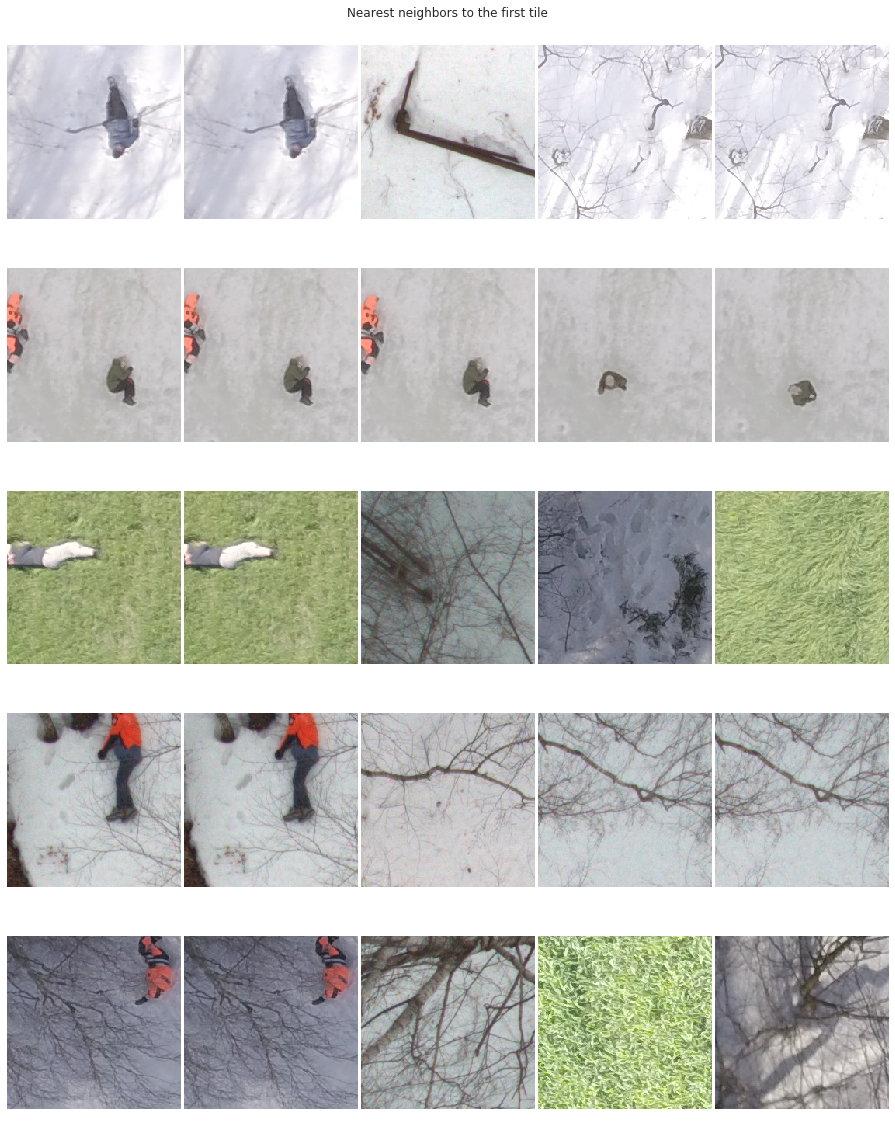

In [125]:
def get_sample_nn(row, column):
    samples = pd_files.sample(row)
    result = []
    for i in samples.index.values:
        result = result + [i]
        result = result + t.get_nns_by_item(i, column-1)
    return result


def get_nn(indices, column):
    result = []
    for i in indices:
        result = result + [i]
        result = result + t.get_nns_by_item(i, column-1)
    return result


columns = 5
rows = 5
# We run get_sample_nn multiple times to get interesting looking indices
# There are a lot of empty spaces, which would not provide good results
# due to data sampling; hence we cherry pick a few by uncommenting and 
# running the below; 
# results = get_sample_nn(rows, columns)
input_indices = [189331, 188970, 220032, 222779, 219586]
results = get_nn(input_indices[:rows], columns)

w = 15
h = 15
fig = plt.figure(figsize=(18, 22))

plt.subplots_adjust(left=0.32, bottom=0, right=1.0, top=0.7, wspace=0.02, hspace=0.02)
plt.title("Nearest neighbors to the first tile")
plt.axis('off')
for i, index in enumerate(results):
    img = np.random.randint(10, size=(h, w))
    fig.add_subplot(rows, columns, i+1)
    img = Image.open(pd_files.path[index], 'r')
    data = img.convert('RGB')
    t_img = torch.from_numpy(np.asarray(data))
    t_img_np = t_img.numpy()
#     plt.title(index)
    plt.axis('off')
    plt.imshow(t_img_np)

plt.show()

### Interpolation between two embeddings
If the embeddings are good, there should be smooth interpolation between two different types of locations.

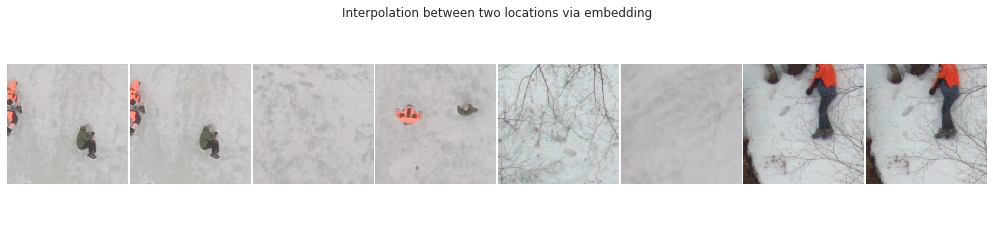

In [126]:
interpolation_size = 6
# interpolate from 185175 to 751688
from scipy.interpolate import interp1d
# These numbers are cherry picked. Once we train for longer, we can remove it
begin_index = 188970 #204543
end_index = 222779
fst = t.get_item_vector(begin_index)
snd = t.get_item_vector(end_index)
linfit = interp1d([1,interpolation_size], np.vstack([fst, snd]), axis=0)

item = []
item = item + [begin_index]
for i in range(0,interpolation_size):    
    item = item + t.get_nns_by_vector(linfit(i+1),1)

item = item + [end_index]
columns = 8
rows = 1


w=15
h=15
fig=plt.figure(figsize=(20,4))
plt.title("Interpolation between two locations via embedding")
plt.subplots_adjust(left=0.32, bottom=0, right=1.0, top=0.7, wspace=0.02, hspace=0.02)
plt.axis('off')
for i, index in enumerate(item):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i+1)
    img = Image.open(pd_files.path[index], 'r')
    data = img.convert('RGB')        
    t_img = torch.from_numpy(np.asarray(data))
    t_img_np = t_img.numpy()
#     plt.title(index)
    plt.axis('off')
    plt.imshow(t_img_np)
    
plt.show()

### PCA and TSNE plots


In [129]:
!rm -rf tensorboard/

In [130]:
writer = SummaryWriter('tensorboard')
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/7
inv_normalize = transforms.Normalize(
    mean=[-0.485 * 0.229, -0.456 * 0.224, -0.406 * 0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

all_outputs = None
all_targets = None
all_data = None
with torch.no_grad():
    model.eval()
    val_loss = 0
    for batch_idx, (data, target) in enumerate(online_eval_loader):
        if cuda:
            data = data.cuda()
        outputs = model(data)
#         outputs = outputs.data.cpu().numpy()
        if all_outputs is None:
#             print("in here")
            all_outputs = outputs.clone()
            all_targets = target.clone()
            all_data = data.clone()
        else:
#             print("nin here")
            all_outputs = torch.cat([outputs, all_outputs], 0)
            all_targets = torch.cat([target, all_targets], 0)
            all_data = torch.cat([data, all_data], 0)

        if batch_idx == 22:
            all_data = torch.stack([inv_normalize(data) for data in all_data],0)
            print(all_outputs.shape, all_targets.shape, all_data.shape)
            writer.add_embedding(all_outputs, metadata=all_data, label_img=all_data)
            all_data = None
            all_outputs = None
            all_targets = None
            torch.cuda.empty_cache()
            break

torch.Size([1288, 16]) torch.Size([1288]) torch.Size([1288, 3, 225, 225])


If you run the following in the commandline, you should see PCA and TSNE Plots. Checking the 'spherical coordinates' box makes the plot look better.

`tensorboard --logdir tensorboard`
#### PCA 
![Interpolation](images/pca.png)
#### TSNE
![TSNE](images/tsne.png)

In [3]:
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
filenames = []
pathstring = '/files/datasets/lacmus-ds/ladd_crop/base'

for file in Path(pathstring).glob("**/*.png"):
    filenames.append((file, file.stat().st_size,
                        file.parts[-2], file.stem))

files_df = pd.DataFrame(list(filenames),
                        columns=["path", "filesize", "x", "y"])
sorted_files = files_df.sort_values("filesize")

result_df = sorted_files.reset_index(drop=True)

display(result_df)

def cleanse_files(df_files):
    """
    lets check filesizes and remove known useless tiles.

    103, 306, 355, 2165, 2146, 2128, 2202 are heavily
    represented and are typically grasslands/ empty / sea.

    Let's remove that from the samples!

    Arguments:
        df_files {pandas dataframe} -- should contain a column named "filesize"

    Returns:
        dataframe -- filtered dataframe with useless file sizes removed
    """
    
    result = df_files
    count = result.filesize.value_counts()
    freq = 1./count
    freq_dict = freq.to_dict()
    result['frequency'] = result['filesize'].map(freq_dict)
    print(len(result))
    return result

display(cleanse_files(result_df))

,path,filesize,x,y
0,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,262191
1,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,226811
2,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,258637
3,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,118763
4,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,134074
5,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,129154
6,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,289111
7,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,258178
8,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,191155
9,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,186276


304544


,path,filesize,x,y,frequency
0,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,262191,0.000377
1,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,226811,0.000377
2,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,258637,0.000377
3,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,118763,0.000377
4,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,134074,0.000377
5,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,129154,0.000377
6,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,289111,0.000377
7,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,258178,0.000377
8,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,191155,0.000377
9,/files/datasets/lacmus-ds/ladd_crop/base/Backg...,835,Background,186276,0.000377
